# Tutorial 10c - Custom Optimization Algorithms

### November 2024

This tutorial demonstrates how to define a custom optimization algorithm in Optiland. There are already several optimization algorithms available in Optiland, including a least squares optimizer, dual annealing, differential evolution, and a generic optimizer that wraps `scipy.optimize.minimize`. While the existing algorithms may cover most use cases, it is sometimes necessary to implement a custom algorithm to meet specific requirements.

In this tutorial, we will create a _random walk optimizer_, which traverses the design space by making random steps and evaluating the objective function at each step. This is a very simple (and inefficient) strategy for optimization, but it will demonstrate how to integrate a custom algorithm into the Optiland framework.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from optiland import analysis, optic, optimization

Our goal will be to optimize the coefficients of an aspheric singlet to minimize the RMS spot size. We start by first defining this singlet with all aspheric coefficients set to zero.

In [2]:
class AsphericSinglet(optic.Optic):
    """Aspheric singlet"""

    def __init__(self):
        super().__init__()

        # add surfaces
        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(
            index=1,
            thickness=7,
            radius=20.0,
            is_stop=True,
            material="N-SF11",
            surface_type="even_asphere",
            conic=0.0,
            coefficients=[0, 0, 0],
        )
        self.add_surface(index=2, thickness=21.56201105)
        self.add_surface(index=3)

        # add aperture
        self.set_aperture(aperture_type="EPD", value=20.0)

        # add field
        self.set_field_type(field_type="angle")
        self.add_field(y=0)

        # add wavelength
        self.add_wavelength(value=0.55, is_primary=True)

Next, we need to define our optimization algorithm. This is a class that inherits from `optimization.OptimizerGeneric`. This class has two requirements:

1. The constructor must accept the optimization problem as an argument. This is an instance of `optimization.OptimizationProblem`.
2. The class must implement the `optimize` method.

The optimization algorithm is as follows:

1. Get current variable values ("position") and the objective function value.
2. Save the initial position in case we want to undo the optimization later (optional, but good practice).
3. Generate a random step.
4. Calculate the objective function at the new position.
5. If the new position is better, accept the step.
6. Continue for the maximum number of steps.
7. Update the variables to the optimal position.

In [3]:
class RandomWalkOptimizer(optimization.OptimizerGeneric):
    def __init__(self, problem):
        super().__init__(problem)

    def optimize(self, max_steps=100, delta=0.1, seed=42):
        # Set random seed
        np.random.seed(seed)

        # Get current position and objective function value
        current_position = [var.value for var in self.problem.variables]
        current_value = self._fun(current_position)
        num_variables = len(current_position)

        # save initial position to be able to revert
        self._x.append(current_position)

        # Save values of each iteration
        values = [current_value]

        for _ in range(max_steps):
            # Generate a random step
            random_step = np.random.randn(num_variables) * delta
            new_position = current_position + random_step

            # Calculate the objective function value at the new position
            new_value = self._fun(new_position)
            values.append(new_value)

            # If the new value is better, accept the step
            if new_value < current_value:
                current_position = new_position
                current_value = new_value

        # Update the variables with the best position
        for idvar, var in enumerate(self.problem.variables):
            var.update(current_position[idvar])

        return values

Let's create and draw the starting point lens.

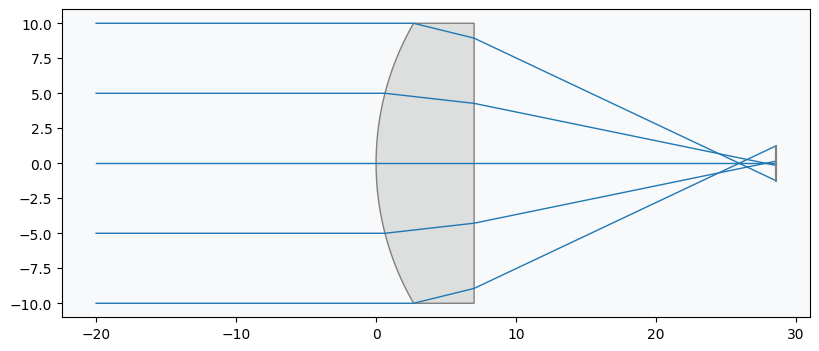

In [4]:
lens = AsphericSinglet()
lens.draw(num_rays=5)

We now create the optimization problem, add our operand (RMS spot size target) and variables (3 aspheric coefficients).

In [5]:
problem = optimization.OptimizationProblem()

In [6]:
input_data = {
    "optic": lens,
    "surface_number": -1,
    "Hx": 0,
    "Hy": 0,
    "num_rays": 5,
    "wavelength": 0.55,
    "distribution": "hexapolar",
}

# add RMS spot size operand
problem.add_operand(
    operand_type="rms_spot_size",
    target=0,
    weight=1,
    input_data=input_data,
)

In [7]:
problem.add_variable(lens, "asphere_coeff", surface_number=1, coeff_number=0)
problem.add_variable(lens, "asphere_coeff", surface_number=1, coeff_number=1)
problem.add_variable(lens, "asphere_coeff", surface_number=1, coeff_number=2)

We print the optimization problem info to see the current status.

In [8]:
problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |               0.612344 |                 0 |
+----+------------------------+-------------------+
+----+----------------+----------+----------+----------+----------+--------------------+
|    | Operand Type   |   Target |   Weight |    Value |    Delta |   Contribution (%) |
|----+----------------+----------+----------+----------+----------+--------------------|
|  0 | rms spot size  |        0 |        1 | 0.782524 | 0.782524 |                100 |
+----+----------------+----------+----------+----------+----------+--------------------+
+----+-----------------+-----------+---------+--------------+--------------+
|    | Variable Type   |   Surface |   Value | Min. Bound   | Max. Bound   |
|----+-----------------+-----------+---------+--------------+--------------|
|  0 | asphere_coeff   |         1 |       0 |              |   

Let's now create an optimizer using our `RandomWalkOptimizer` class. We pass the optimization problem as an argument.

In [9]:
optimizer = RandomWalkOptimizer(problem)

Finally, we can run the optimization by calling the `optimize`. We choose to run the optimization for 1000 steps and use a `delta` value of 0.1. The `delta` value controls the size of the step in each iteration.

In [10]:
values = optimizer.optimize(max_steps=1000, delta=0.1)

On the author's machine, the optimization completes in 2 seconds. Let's print the problem information to see whether optimization was successful.

In [11]:
problem.info()

+----+------------------------+-------------------+
|    |   Merit Function Value |   Improvement (%) |
|----+------------------------+-------------------|
|  0 |            5.48352e-06 |           99.9991 |
+----+------------------------+-------------------+
+----+----------------+----------+----------+------------+------------+--------------------+
|    | Operand Type   |   Target |   Weight |      Value |      Delta |   Contribution (%) |
|----+----------------+----------+----------+------------+------------+--------------------|
|  0 | rms spot size  |        0 |        1 | 0.00234169 | 0.00234169 |                100 |
+----+----------------+----------+----------+------------+------------+--------------------+
+----+-----------------+-----------+--------------+--------------+--------------+
|    | Variable Type   |   Surface |        Value | Min. Bound   | Max. Bound   |
|----+-----------------+-----------+--------------+--------------+--------------|
|  0 | asphere_coeff   |     

Indeed, the objective function value is minimized. We also draw the lens and generate the spot diagram to confirm.

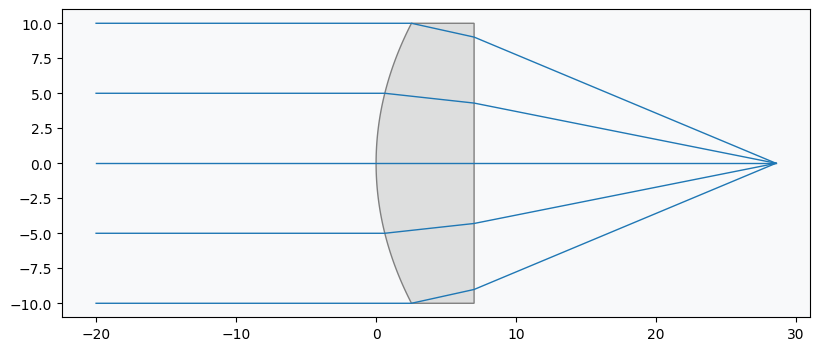

In [12]:
lens.draw(num_rays=5)

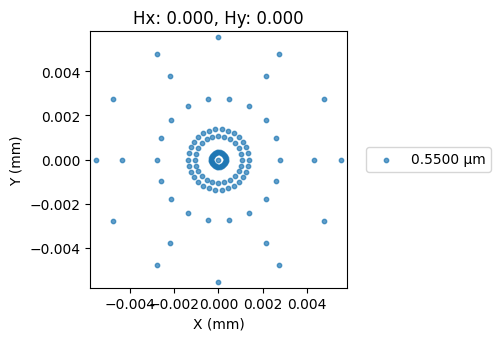

In [13]:
spot = analysis.SpotDiagram(lens)
spot.view()

Recall that we also saved the values of the objective function in each iteration. We can now use these values to plot the convergence of the objective function over the 1000 iterations.

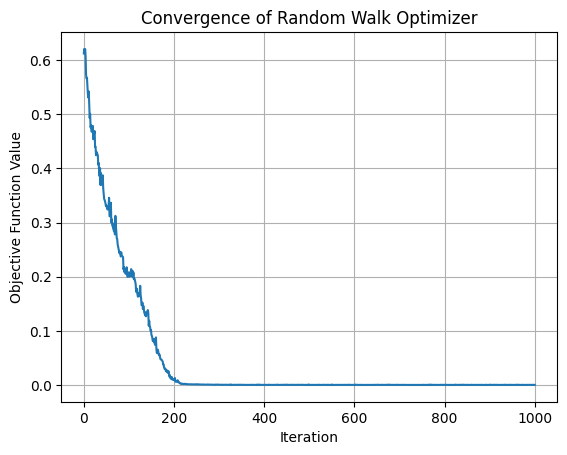

In [14]:
plt.plot(values)
plt.xlabel("Iteration")
plt.ylabel("Objective Function Value")
plt.title("Convergence of Random Walk Optimizer")
plt.grid(True)
plt.show()

We can clearly see that the optimization converges within about 250 iterations. We can therefore conclude that the random walk optimizer is effective for this problem. For improved performance, we might consider adding a stopping condition in the future to avoid unnecessary iterations.

Conclusions:

- This tutorial showed how to add custom optimization algorithms in Optiland.
- A custom optimizer inherits from `optimization.OptimizerGeneric` and it must 1) accept the optimization problem as an argument and 2) implement the `optimize` method.
- The methods shown here can be used to define any arbitrary optimization algorithm. Likewise, existing optimization libraries can be built into Optiland using this approach.